In [56]:
import numpy as np
from scipy import stats
from scipy.special import gammaln
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
import matplotlib.pyplot as plt

In [73]:
import numpy as np
import scipy.stats as stats
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns

# Import de la librairie particles
import particles
from particles import state_space_models as ssm
from particles import distributions as dists

# Configuration visuelle
sns.set_style("whitegrid")

# =============================================================================
# 1. DISTRIBUTIONS PERSONNALISÉES (Version "Naïve" / Standard)
# =============================================================================

class StudentFactorDist(dists.ProbDist):
    """
    Distribution multivariée pour la Copule Factorielle Student-t.
    Méthode : Calcul direct de la matrice de covariance Sigma (sans Woodbury).
    """
    def __init__(self, loadings, nu=5.0):
        # loadings C : (N_particules, n_series, n_facteurs)
        self.C = loadings 
        self.nu = nu
        
        # Gestion des dimensions si on est en mode simulation (pas de particules)
        if self.C.ndim == 2:
            self.C = self.C[np.newaxis, :, :] # (1, n, p)
            
        self.N_part = self.C.shape[0]
        self.n = self.C.shape[1]
        self.p = self.C.shape[2]

    def _compute_mahalanobis_and_det(self, x):
        """
        Calcule log|Sigma| et le terme quadratique x^T * Sigma^-1 * x
        Sigma = C * C^T + I (Matrice n x n)
        """
        # 1. Construction de Sigma (N_part, n, n)
        # C (N, n, p)  @  C.T (N, p, n)  -> (N, n, n)
        Ct = self.C.transpose(0, 2, 1)
        CCt = np.matmul(self.C, Ct)
        
        # Ajout de l'identité (bruit idiosyncratique standardisé)
        I_n = np.eye(self.n)[None, :, :]
        Sigma = CCt + I_n
        
        # 2. Préparation de x (N_part, n, 1)
        x_col = x.reshape(self.N_part, self.n, 1)
        
        try:
            # 3. Décomposition de Cholesky : Sigma = L * L.T
            # Coût : O(n^3) - C'est ici que c'est plus lent que Woodbury si n est grand
            L = np.linalg.cholesky(Sigma)
            
            # 4. Log-Déterminant : 2 * somme(log(diag(L)))
            # np.diagonal récupère la diagonale sur les deux derniers axes
            log_det = 2 * np.sum(np.log(np.diagonal(L, axis1=1, axis2=2)), axis=1)
            
            # 5. Terme quadratique : x.T * Sigma^-1 * x
            # On résout Sigma * z = x  <=> L * L.T * z = x
            # np.linalg.solve gère ça automatiquement
            z = np.linalg.solve(Sigma, x_col)
            
            # Produit scalaire final : x.T @ z
            quad_form = np.matmul(x_col.transpose(0, 2, 1), z).flatten()
            
            return log_det, quad_form
            
        except np.linalg.LinAlgError:
            # En cas de problème numérique (matrice non définie positive)
            return np.full(self.N_part, np.inf), np.full(self.N_part, np.inf)

    def logpdf(self, u):
        """Calcule la log-vraisemblance de la copule"""
        u = np.clip(u, 1e-9, 1 - 1e-9)
        x = stats.t.ppf(u, df=self.nu)  # (n,)
        
        # Répliquer l'observation pour chaque particule
        x = np.tile(x, (self.N_part, 1))  # (N_part, n)
        
        log_det, quad = self._compute_mahalanobis_and_det(x)
        
        n, nu = self.n, self.nu
        
        log_const = (gammaln((nu + n) / 2) - gammaln(nu / 2)
                    + n * gammaln(nu / 2) - n * gammaln((nu + 1) / 2))
        
        log_marg = -((nu + 1) / 2) * np.sum(np.log(1 + x**2 / nu), axis=1)
        log_joint = -((nu + n) / 2) * np.log(1 + quad / nu)
        
        return -0.5 * log_det + log_const + log_joint - log_marg
    
    def rvs(self, size=None):
        """Simulation d'une observation"""
        # On prend le premier loading (simulation séquentielle)
        C_sim = self.C[0] 
        n, p = C_sim.shape
        
        # 1. Variable de mélange W ~ Chi2(nu) / nu
        w = np.random.chisquare(df=self.nu) / self.nu
        
        # 2. Facteurs Latents (Z) et Bruits (e) ~ Normal(0, 1)
        Z = np.random.normal(0, 1, size=p)
        e = np.random.normal(0, 1, size=n)
        
        # 3. Variable Latente X (Multivariée Student)
        # X = sqrt(1/W) * (C*Z + e)
        X = np.sqrt(1.0 / w) * (C_sim @ Z + e)
        
        # 4. Transformation vers Uniforme [0,1]
        # On doit diviser par l'écart-type implicite de la partie gaussienne
        variances_gauss = 1 + np.sum(C_sim**2, axis=1)
        stds = np.sqrt(variances_gauss)
        
        return stats.t.cdf(X / stds, df=self.nu)

# =============================================================================
# 2. MODÈLE STATE-SPACE
# =============================================================================

class StudentFactorCopulaSSM(ssm.StateSpaceModel):
    def __init__(self, n_series=10, n_factors=2, mu=0.0, phi=0.95, sigma=0.1, nu=5.0):
        self.n = n_series
        self.p = n_factors
        self.dim = n_series * n_factors # Taille du vecteur d'état
        self.mu = mu
        self.phi = phi
        self.sigma = sigma
        self.nu = nu
        
    def PX0(self):
        """Distribution initiale de l'état alpha_0"""
        scale = self.sigma / np.sqrt(1 - self.phi**2)
        # CORRECTION CRITIQUE : Utilisation de dists.IID
        return dists.IID(dists.Normal(loc=self.mu, scale=scale), self.dim)
        
    def PX(self, t, xp):
        """Transition de l'état : alpha_t | alpha_{t-1}"""
        # xp est (N_particules, dim). dists.Normal gère le broadcasting.
        return dists.Normal(loc=self.mu + self.phi * (xp - self.mu), 
                            scale=self.sigma)

    def PY(self, t, xp, x):
        """Vraisemblance : p(y_t | alpha_t)"""
        # On remet l'état à plat (N, dim) sous forme matricielle (N, n, p)
        # pour que la classe StudentFactorDist puisse faire les calculs
        loadings = x.reshape(-1, self.n, self.p)
        return StudentFactorDist(loadings, nu=self.nu)

# =============================================================================
# 3. EXÉCUTION
# =============================================================================

if __name__ == "__main__":
    # Paramètres
    T_steps = 100       # Durée de la simulation
    N_series = 10       # Nombre d'actifs (Garder < 50 sans Woodbury)
    N_factors = 1       # Nombre de facteurs
    N_particles = 1000  # Nombre de particules
    
    print("=== Démarrage ===")
    print(f"Modèle: Student-t Copula avec {N_series} séries et {N_factors} facteur(s)")
    
    # 1. Simulation des données (Vérité terrain)
    true_model = StudentFactorCopulaSSM(n_series=N_series, n_factors=N_factors, nu=5.0)
    true_states, data = true_model.simulate(T_steps)
    true_states_arr = np.array(true_states)
    
    print(f"Données simulées. Shape: {len(data)} x {N_series}")
    
    # 2. Filtrage Particulaire
    # ssm.Bootstrap lie le modèle aux données
    fk = ssm.Bootstrap(ssm=true_model, data=data)
    
    # Lancement de l'algorithme SMC
    pf = particles.SMC(fk=fk, N=N_particles, resampling='systematic', verbose=True)
    pf.run()
    
    print(f"Log-Vraisemblance finale : {pf.logLt:.4f}")
    
    # 3. Visualisation
    # On regarde l'état latent numéro 0 (correspondant au loading du facteur 1 sur la série 1)
    
    # Extraction des estimations (Moyenne pondérée des particules)
    est_states = []
    
    # Suivi de l'index 0 du vecteur d'état
    idx_track = 0 
    
    for t in range(T_steps):
        # Moyenne pondérée à l'instant t
        avg = np.average(pf.hist.X[t][:, idx_track], weights=pf.hist.wgts[t].W)
        est_states.append(avg)
    
    # Graphique
    
    plt.figure(figsize=(12, 6))
    plt.plot(true_states_arr[:, idx_track], 'k-', label='Vrai Paramètre', linewidth=2)
    plt.plot(est_states, 'r--', label='Estimé (PF)', linewidth=2)
    plt.title(f"Filtrage Particulaire (Sans Woodbury) - Série {N_series}, Particules {N_particles}")
    plt.ylabel("Valeur du facteur latent")
    plt.xlabel("Temps")
    plt.legend()
    plt.tight_layout()
    plt.show()

=== Démarrage ===
Modèle: Student-t Copula avec 10 séries et 1 facteur(s)


ValueError: Output size (1,) is not compatible with broadcast dimensions of inputs (1, 10).

In [66]:
# 1. Configuration
T = 50       # Horizon temps
N_series = 20 # Nombre d'actifs (ex: 200 dans le papier)
N_factors = 2 # Nombre de facteurs (p)
N_part = 1000 # Nombre de particules

# 2. Instanciation du modèle (Student-t par exemple)
my_model = StudentFactorCopulaSSM(n_series=N_series, 
                                  n_factors=N_factors, 
                                  nu=5.0, 
                                  phi=0.95, 
                                  sigma=0.1)

# 3. Simulation de données synthétiques (pour tester)
true_states, data = my_model.simulate(T)

# 4. Lancement du Filtre Bootstrap
fk = ssm.Bootstrap(ssm=my_model, data=data) # Feynman-Kac formalism
pf = particles.SMC(fk=fk, N=N_part, resampling='multinomial', verbose=True)
pf.run()

# 5. Résultats
print(f"Log-vraisemblance estimée : {pf.logLt}")

# Récupérer les moyennes filtrées des états (loadings)
# pf.X est une liste de temps, contenant les particules et poids
filtered_means = [np.average(X, weights=W, axis=0) for X, W in zip(pf.X, pf.W)]

TypeError: LocScaleDist.__init__() got an unexpected keyword argument 'size'

In [57]:
class GaussianCopulaSSM(ssm.StateSpaceModel):
    """
    Gaussian copula with time-varying factor loadings.
    
    State equation: lambda_{t+1} = mu + phi * (lambda_t - mu) + eta_t
    Observation: u_t ~ GaussianCopula(R_t) where R_t depends on lambda_t
    """
    
    default_params = {'mu': 0.5, 'phi': 0.95, 'sigma': 0.1, 'n_series': 5}
    
    def PX0(self):
        """Initial distribution of the state."""
        scale = self.sigma / np.sqrt(1 - self.phi**2)
        return dists.Normal(loc=self.mu, scale=scale)
    
    def PX(self, t, xp):
        """Transition density: p(x_t | x_{t-1})"""
        mean = self.mu + self.phi * (xp - self.mu)
        return dists.Normal(loc=mean, scale=self.sigma)
    
    def PY(self, t, xp, x):
        """Observation density: p(y_t | x_t)"""
        return GaussianCopulaDist(x, self.n_series)


class StudentTCopulaSSM(ssm.StateSpaceModel):
    """
    Student-t copula with time-varying factor loadings.
    """
    
    default_params = {'mu': 0.5, 'phi': 0.95, 'sigma': 0.1, 'n_series': 5, 'nu': 5.0}
    
    def PX0(self):
        """Initial distribution of the state."""
        scale = self.sigma / np.sqrt(1 - self.phi**2)
        return dists.Normal(loc=self.mu, scale=scale)
    
    def PX(self, t, xp):
        """Transition density: p(x_t | x_{t-1})"""
        mean = self.mu + self.phi * (xp - self.mu)
        return dists.Normal(loc=mean, scale=self.sigma)
    
    def PY(self, t, xp, x):
        """Observation density: p(y_t | x_t)"""
        return StudentTCopulaDist(x, self.n_series, self.nu)


# =============================================================================
# 2. Define Copula Distributions compatible with particles
# =============================================================================

class GaussianCopulaDist:
    """Gaussian copula distribution compatible with particles library."""
    
    def __init__(self, state, n_series):
        """
        state: array of shape (N_particles,) - the latent factor loading
        n_series: number of series in the copula
        """
        self.state = np.atleast_1d(state)
        self.n = n_series
    
    def logpdf(self, u):
        """
        Log-density of Gaussian copula.
        u: observation vector of shape (n_series,)
        Returns: array of shape (N_particles,)
        """
        u = np.asarray(u)
        u = np.clip(u, 1e-10, 1 - 1e-10)
        
        # Transform to normal quantiles
        x = stats.norm.ppf(u)  # shape (n_series,)
        
        # For each particle, compute log-density
        N = len(self.state)
        logpdf = np.zeros(N)
        
        for i in range(N):
            lam = np.tanh(self.state[i])  # transform to (-1, 1)
            rho = lam**2
            
            # Correlation matrix: R = (1-rho)*I + rho*ones
            # This is equicorrelation structure
            R = np.eye(self.n) * (1 - rho) + rho * np.ones((self.n, self.n))
            
            try:
                # Gaussian copula: c(u) = |R|^{-1/2} * exp(-0.5 * x'(R^{-1} - I)x)
                R_inv = np.linalg.inv(R)
                sign, log_det = np.linalg.slogdet(R)
                
                quad = x @ (R_inv - np.eye(self.n)) @ x
                logpdf[i] = -0.5 * log_det - 0.5 * quad
            except np.linalg.LinAlgError:
                logpdf[i] = -np.inf
        
        return logpdf


class StudentTCopulaDist:
    """Student-t copula distribution compatible with particles library."""
    
    def __init__(self, state, n_series, nu):
        self.state = np.atleast_1d(state)
        self.n = n_series
        self.nu = nu
    
    def logpdf(self, u):
        """
        Log-density of Student-t copula.
        u: observation vector of shape (n_series,)
        Returns: array of shape (N_particles,)
        """
        u = np.asarray(u)
        u = np.clip(u, 1e-10, 1 - 1e-10)
        
        # Transform to t quantiles
        x = stats.t.ppf(u, df=self.nu)
        
        N = len(self.state)
        n = self.n
        nu = self.nu
        logpdf = np.zeros(N)
        
        # Constant terms
        log_const = (gammaln((nu + n) / 2) - gammaln(nu / 2)
                    + n * gammaln(nu / 2) - n * gammaln((nu + 1) / 2))
        
        # Marginal contribution (same for all particles)
        log_marginals = -((nu + 1) / 2) * np.sum(np.log(1 + x**2 / nu))
        
        for i in range(N):
            lam = np.tanh(self.state[i])
            rho = lam**2
            R = np.eye(n) * (1 - rho) + rho * np.ones((n, n))
            
            try:
                R_inv = np.linalg.inv(R)
                sign, log_det = np.linalg.slogdet(R)
                
                quad = x @ R_inv @ x
                log_joint = -((nu + n) / 2) * np.log(1 + quad / nu)
                
                logpdf[i] = -0.5 * log_det + log_const + log_joint - log_marginals
            except np.linalg.LinAlgError:
                logpdf[i] = -np.inf
        
        return logpdf

In [58]:
# =============================================================================
# 3. Simulate Data from the Models
# =============================================================================

def simulate_data(model, T=200):
    """Simulate states and observations from the model."""
    n = model.n_series
    is_student = isinstance(model, StudentTCopulaSSM)
    
    # Simulate states
    states = np.zeros(T)
    scale0 = model.sigma / np.sqrt(1 - model.phi**2)
    states[0] = np.random.normal(model.mu, scale0)
    
    for t in range(1, T):
        mean = model.mu + model.phi * (states[t-1] - model.mu)
        states[t] = np.random.normal(mean, model.sigma)
    
    # Simulate observations
    observations = np.zeros((T, n))
    
    for t in range(T):
        lam = np.tanh(states[t])
        rho = lam**2
        R = np.eye(n) * (1 - rho) + rho * np.ones((n, n))
        
        if is_student:
            nu = model.nu
            z = np.random.multivariate_normal(np.zeros(n), R)
            chi2 = np.random.chisquare(nu)
            x = z * np.sqrt(nu / chi2)
            observations[t] = stats.t.cdf(x, df=nu)
        else:
            x = np.random.multivariate_normal(np.zeros(n), R)
            observations[t] = stats.norm.cdf(x)
    
    return states, observations


In [59]:
# =============================================================================
# 4. Run Bootstrap Particle Filter
# =============================================================================

def run_particle_filter(model, observations, N_particles=500):
    """Run bootstrap particle filter and compute log-likelihood."""
    T = len(observations)
    
    # Create bootstrap filter
    fk = ssm.Bootstrap(ssm=model, data=observations)
    
    # Run SMC
    pf = particles.SMC(fk=fk, N=N_particles, store_history=True)
    pf.run()
    
    # Log-likelihood
    log_likelihood = pf.logLt
    
    # Filtering means
    filtering_means = np.zeros(T)
    for t in range(T):
        filtering_means[t] = np.average(pf.hist.X[t], weights=pf.hist.wgts[t].W)
    
    return log_likelihood, filtering_means

Copula State Space Models with Bootstrap Particle Filter

1. GAUSSIAN COPULA MODEL
----------------------------------------
Simulating data...
Running particle filter (N=500)...
Log-likelihood: 20.55

2. STUDENT-T COPULA MODEL
----------------------------------------
Simulating data...
Running particle filter (N=500)...
Log-likelihood: 82.63

3. MODEL COMPARISON (cross-fitting)
----------------------------------------
Gaussian model on Student-t data: LL = 59.87
Student-t model on Gaussian data: LL = 7.15


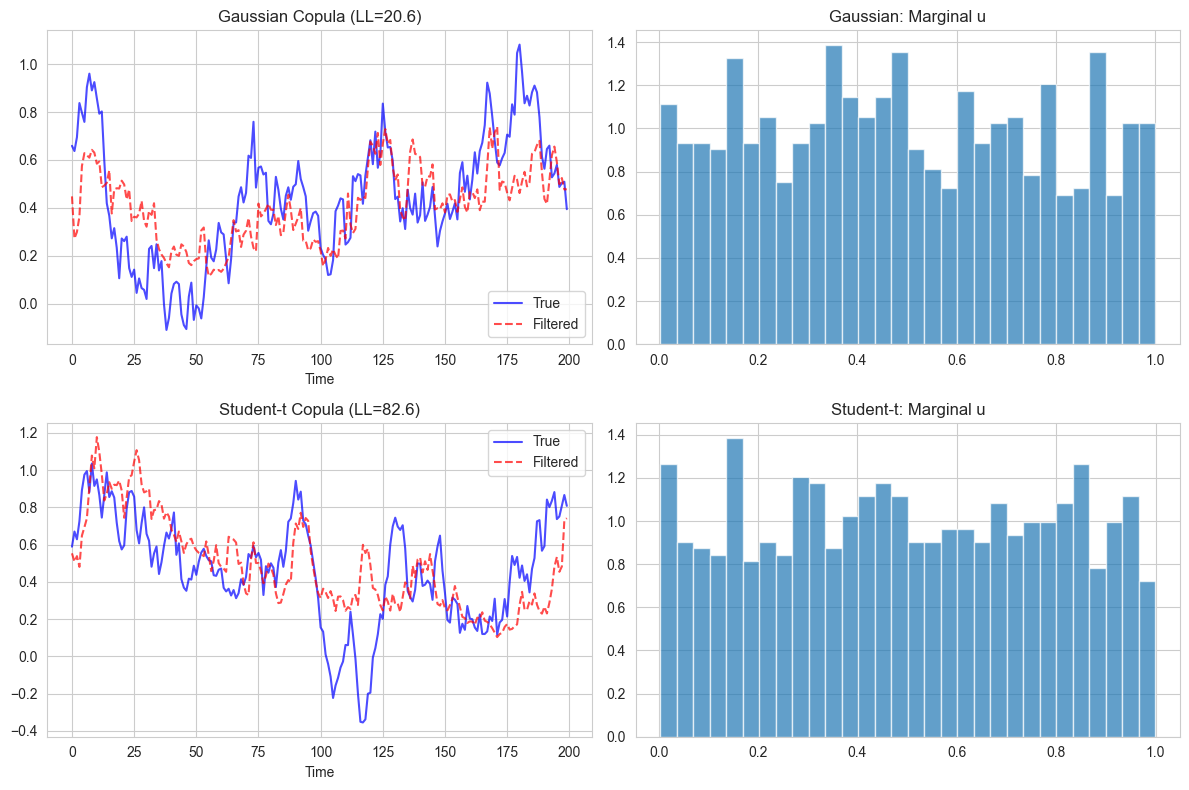

In [60]:
np.random.seed(42)

T = 200
n_series = 5
N_particles = 500

print("=" * 60)
print("Copula State Space Models with Bootstrap Particle Filter")
print("=" * 60)

# --- Gaussian Copula ---
print("\n1. GAUSSIAN COPULA MODEL")
print("-" * 40)

gauss_model = GaussianCopulaSSM(mu=0.5, phi=0.95, sigma=0.1, n_series=n_series)

print("Simulating data...")
true_states_gauss, obs_gauss = simulate_data(gauss_model, T)

print(f"Running particle filter (N={N_particles})...")
ll_gauss, filtered_gauss = run_particle_filter(gauss_model, obs_gauss, N_particles)
print(f"Log-likelihood: {ll_gauss:.2f}")

# --- Student-t Copula ---
print("\n2. STUDENT-T COPULA MODEL")
print("-" * 40)

t_model = StudentTCopulaSSM(mu=0.5, phi=0.95, sigma=0.1, n_series=n_series, nu=5.0)

print("Simulating data...")
true_states_t, obs_t = simulate_data(t_model, T)

print(f"Running particle filter (N={N_particles})...")
ll_t, filtered_t = run_particle_filter(t_model, obs_t, N_particles)
print(f"Log-likelihood: {ll_t:.2f}")

# --- Model comparison ---
print("\n3. MODEL COMPARISON (cross-fitting)")
print("-" * 40)

ll_gauss_on_t, _ = run_particle_filter(gauss_model, obs_t, N_particles)
print(f"Gaussian model on Student-t data: LL = {ll_gauss_on_t:.2f}")

ll_t_on_gauss, _ = run_particle_filter(t_model, obs_gauss, N_particles)
print(f"Student-t model on Gaussian data: LL = {ll_t_on_gauss:.2f}")

# --- Plot ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(true_states_gauss, 'b-', alpha=0.7, label='True')
axes[0, 0].plot(filtered_gauss, 'r--', alpha=0.7, label='Filtered')
axes[0, 0].set_title(f'Gaussian Copula (LL={ll_gauss:.1f})')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Time')

axes[0, 1].hist(obs_gauss.flatten(), bins=30, density=True, alpha=0.7)
axes[0, 1].set_title('Gaussian: Marginal u')

axes[1, 0].plot(true_states_t, 'b-', alpha=0.7, label='True')
axes[1, 0].plot(filtered_t, 'r--', alpha=0.7, label='Filtered')
axes[1, 0].set_title(f'Student-t Copula (LL={ll_t:.1f})')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Time')

axes[1, 1].hist(obs_t.flatten(), bins=30, density=True, alpha=0.7)
axes[1, 1].set_title('Student-t: Marginal u')

plt.tight_layout()
plt.show()